<div class="alert alert-block alert-success" align=center>
    <h1>ALBERO DI DECISIONE</h1>
</div>

In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
from sklearn.utils import resample
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import BaggingRegressor
from sklearn.ensemble import AdaBoostRegressor

In [2]:
def split(dataframe):
    
    # Si toglie la colonna da predire
    X = dataframe.drop(columns=['Sale_Price'], axis =1)

    # Si isola la colonna da predire
    y = dataframe['Sale_Price']

    X_train_80, X_test, y_train_80, y_test = train_test_split(X, y, test_size = 0.20, random_state = 3)
    
    return X_train_80, X_test, y_train_80, y_test

In [3]:
def divide(dataframe):
    
    # Si separano le feature dal prezzo
    X_train = dataframe.drop(columns = ['Sale_Price'], axis = 1)
    
    y_train = dataframe['Sale_Price']
    
    return X_train, y_train

Si importa il dataset sporco con outliers.

In [4]:
df = pd.read_csv('dataset_enc.csv')

In [5]:
X_train_80, X_test, y_train_80, y_test = split(df)

Si importano il training-set e il test-set del dataset sporco ma senza outliers.

In [6]:
df_train_wo_out = pd.read_csv('training_wo_outliers.csv')

In [7]:
X_train_wo_out, y_train_wo_out = divide(df_train_wo_out)

Si importa il training-set pulito con outliers su cui è stata applicata la tecnica dell'RFECV con gli outliers.

In [8]:
df_clean_train = pd.read_csv('df_train_RFECV.csv')

In [9]:
X_clean_train_80, y_clean_train_80 = divide(df_clean_train)

Si importa il training-set pulito ma senza outliers su cui è stata applicata RFECV.

In [10]:
df_clean_train_wo_out = pd.read_csv('df_train_RFECV.csv') 

In [11]:
X_clean_train_wo_out, y_clean_train_wo_out = divide(df_clean_train_wo_out)

E infine il test-set pulito su cui è stata applicata RFECV.

In [12]:
df_clean_test = pd.read_csv('df_test_RFECV.csv')

In [13]:
X_clean_test, y_clean_test = divide(df_clean_test)

> Split per Cross-Validation

Si dividono i training-set per poter effettuare Cross-Validation

In [14]:
def split_cross(X_train, y_train):
    
    X_train_new, X_valid, y_train_new, y_valid  = train_test_split(X_train, y_train, test_size = 0.25, random_state = 3)
    
    return X_train_new, X_valid, y_train_new, y_valid

In [15]:
X_train_80, X_valid, y_train_80, y_valid = split_cross(X_train_80, y_train_80)

In [16]:
X_train_wo_out, X_valid_wo_out, y_train_wo_out, y_valid_wo_out = split_cross(X_train_wo_out, y_train_wo_out)

In [17]:
X_clean_train_80, X_clean_valid, y_clean_train_80, y_clean_valid = split_cross(X_clean_train_80, y_clean_train_80)

In [18]:
X_clean_train_wo_out, X_clean_valid_wo_out, y_clean_train_wo_out, y_clean_valid_wo_out = split_cross(X_clean_train_wo_out, y_clean_train_wo_out)

### Funzione che implementa la ricerca del miglior numero di foglie

In [19]:
# Funzione per trovare l'mae in base al numero di foglie dell'albero
def cv_max_leaves(X_train, X_valid, X_test, y_train, y_valid, y_test, l_min = 2, l_max = 50, l_step = 1):
    
    # Array per salvarsi i risultati ottenuti
    MAE = []
    MAE_plot= []
    
    # ------------------------------------------------------------------

    # Ciclo for per vedere i cambiamenti dell'mae all'aumentare delle foglie
    for num_leaves in range(l_min, l_max, l_step):
        
        # Si crea l'albero con il numero di foglie specificato da 'num_leaves'
        model = DecisionTreeRegressor(max_leaf_nodes = num_leaves)
        model.fit(X_train,y_train)

        # Si calcola l'mae per il training-set
        y_pred_train = model.predict(X_train)
        MAE_train = mean_absolute_error(y_true = y_train, y_pred = y_pred_train)
        
        # Si calcola l'mse per il test-set
        y_pred_valid = model.predict(X_valid)
        MAE_valid  = mean_absolute_error(y_true = y_valid,  y_pred = y_pred_valid)
        
        # L'array mse contiene elementi che a loro volta sono array di 3 elementi: 
        # numero di foglie usate, errore sul train e errore sul test
        MAE_plot += [ [num_leaves, MAE_train, MAE_valid] ]
        
    # ------------------------------------------------------------------
        
    # Si cerca l'errore migliore (il più piccolo)
    minimum_error = MAE_plot[0][2]
    best_num_leaves = MAE_plot[0][0]
    
    for i in range(len(MAE_plot)):
        if(minimum_error > MAE_plot[i][2]):
            minimum_error = MAE_plot[i][2]
            best_num_leaves = MAE_plot[i][0]

    # Si crea l'albero con il numero di foglie specificato da 'num_leaves'
    best_model = DecisionTreeRegressor(max_leaf_nodes = best_num_leaves)
    best_model.fit(X_train, y_train)
    
    # Calcolo dell'errore assoluto per il test-set
    y_pred_test = best_model.predict(X_test)
    MAE_test = mean_absolute_error(y_true = y_test, y_pred = y_pred_test)
    
    # L'array best_n_estimators contiene elementi che a loro volta sono array di 2 elementi: 
    # numero di vicini, errore assoluto sul test
    MAE += [best_num_leaves, MAE_test]
    
    MAE_plot = np.array(MAE_plot)
    
    # Grafico y reali vs y predette
    plt.scatter(y_test, y_pred_test)
    plt.xlabel('Actual values')
    plt.ylabel('Predicted values')
    
    # Grafico per vedere l'andamento dell'mse
    fig, ax = plt.subplots()
    ax.plot(MAE_plot[:,0], MAE_plot[:,1], "x:", label = "Train")
    ax.plot(MAE_plot[:,0], MAE_plot[:,2], "s-", label = "Valid")
    plt.xlabel("Number of leaves")
    plt.ylabel("MAE")
    ax.legend()
    ax.grid()
    
    # Calcolo dello score
    score = r2_score(y_test, y_pred_test)
    
    #dataframe per il confronto finale dei prezzi predetti
    dataframe_diff = pd.DataFrame({'Actual Value' : y_test, 'Predicted Value' : y_pred_test, 'Difference' : abs(y_test - y_pred_test)})
    
    
    return MAE, score, dataframe_diff

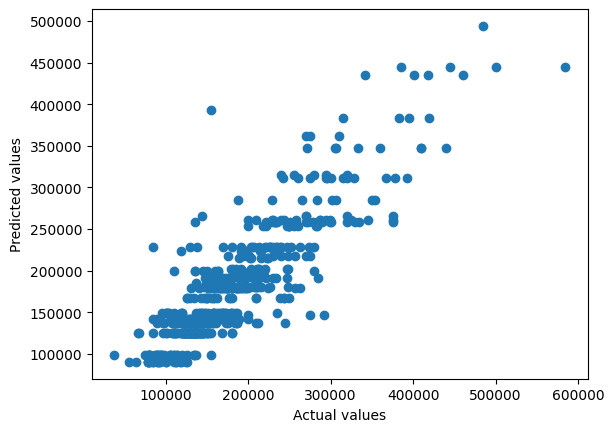

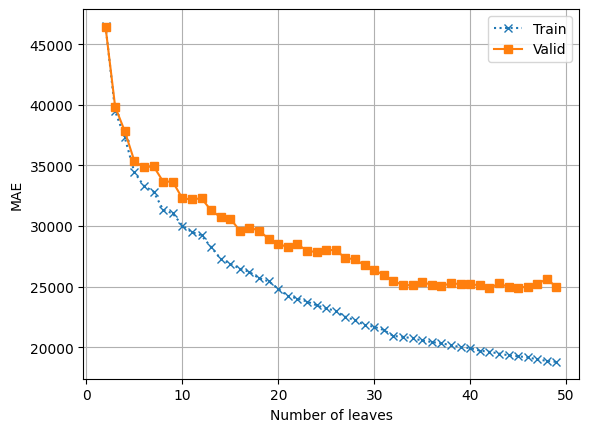

In [20]:
MAE, score, dataframe_diff = cv_max_leaves(X_train_80, X_valid, X_test, y_train_80, y_valid, y_test, l_min = 2, l_max = 50)

In [21]:
print("Errore: ", MAE[1])
print("Score: ", score)
print("Miglior numero di foglie: ", MAE[0])

Errore:  25003.2194015864
Score:  0.7648253692708397
Miglior numero di foglie:  42


Ora si prova sul dataset sporco senza outliers.

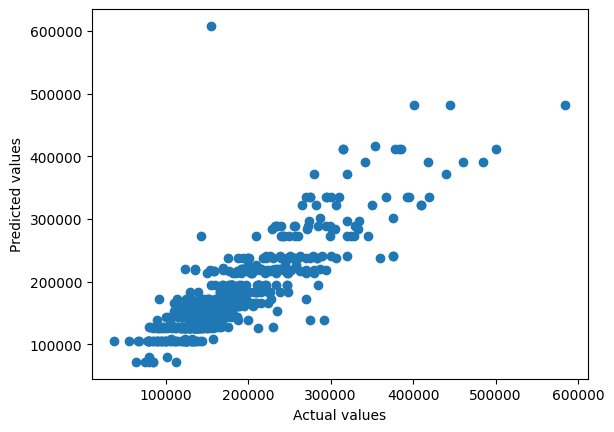

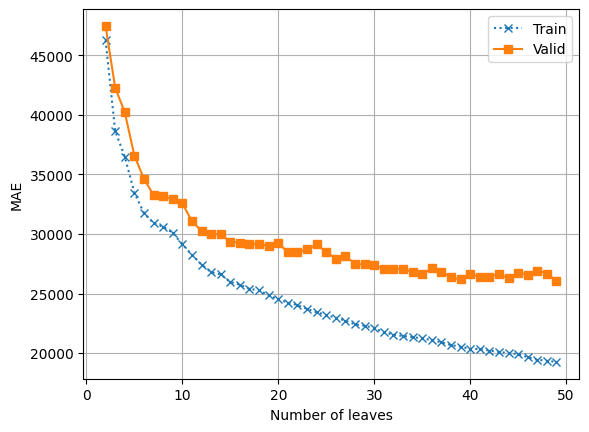

In [22]:
MAE_wo_out, score_wo_out, dataframe_diff = cv_max_leaves(X_train_wo_out, X_valid_wo_out, X_test, y_train_wo_out, y_valid_wo_out, y_test, l_min = 2, l_max = 50)

In [23]:
print("Errore: ", MAE_wo_out[1])
print("Score: ", score_wo_out)
print("Miglior numero di foglie: ", MAE_wo_out[0])

Errore:  25785.412608776893
Score:  0.7261408476294975
Miglior numero di foglie:  49


Ora sul dataset pulito con outliers.

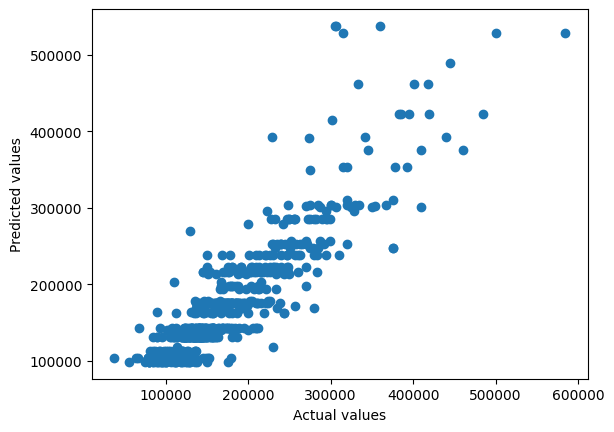

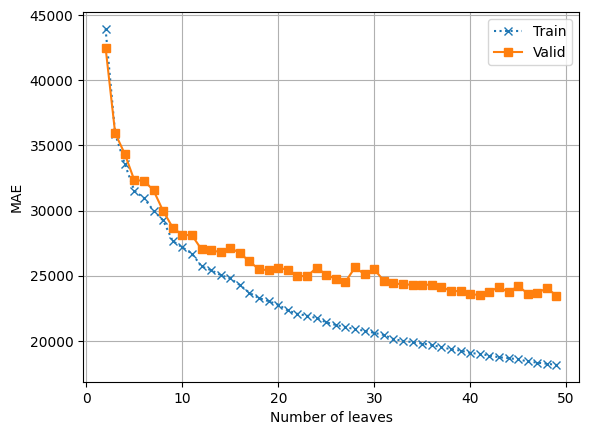

In [24]:
MAE_clean, score_clean, dataframe_diff = cv_max_leaves(X_clean_train_80, X_clean_valid, X_clean_test, y_clean_train_80, y_clean_valid, y_clean_test, l_min = 2, l_max = 50)

In [25]:
print("Errore: ", MAE_clean[1])
print("Score: ", score_clean)
print("Miglior numero di foglie: ", MAE_clean[0])

Errore:  24924.825082687228
Score:  0.7510945757182457
Miglior numero di foglie:  49


E infine sul dataset pulito senza outliers.

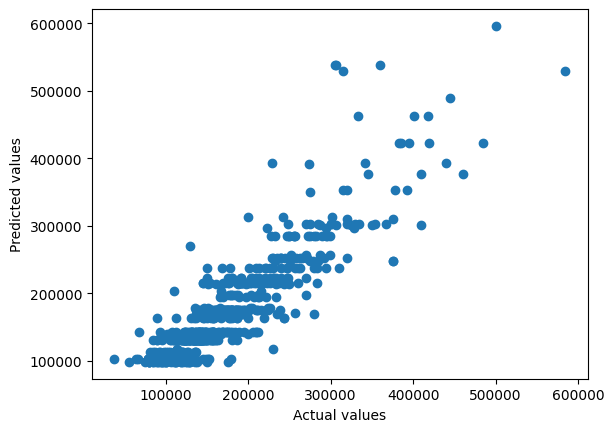

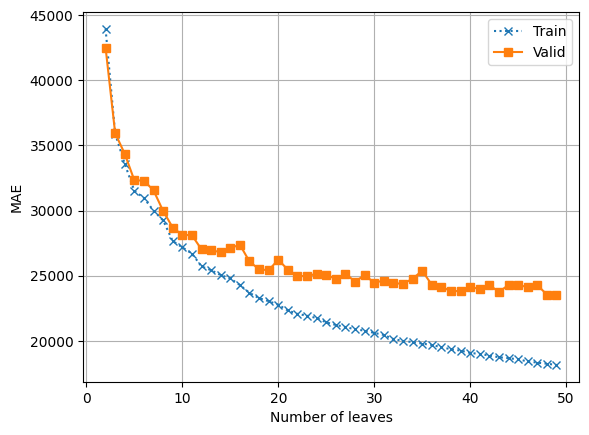

In [27]:
MAE_clean_wo_out, score_clean_wo_out, dataframe_confronto= cv_max_leaves(X_clean_train_wo_out, X_clean_valid_wo_out, X_clean_test, y_clean_train_wo_out, y_clean_valid_wo_out, y_clean_test, l_min = 2, l_max = 50)

In [28]:
print("Errore: ", MAE_clean_wo_out[1])
print("Score: ", score_clean_wo_out)
print("Miglior numero di foglie: ", MAE_clean_wo_out[0])

Errore:  24980.680827852186
Score:  0.7493165163527129
Miglior numero di foglie:  48


Si esporta il dataframe dove si predice meglio

In [29]:
dataframe_confronto = pd.concat([X_clean_test, dataframe_confronto], axis = 1)
dataframe_confronto.to_csv(r'df_confronto_DT.csv', index = False)

<div class="alert alert-block alert-warning">
<b>Considerazioni</b>
</div>

Dall'analisi di questi modelli risulta che vi è un peggioramento nel dataset iniziale senza outliers il quale, nelle predizioni, cala di circa il 4%, dal 0.7648253692708397 al 0.7261408476294975. Cambia inoltre il numero di foglie necessario per raggiungere il miglior risultato, da 42 a 49.

Per quanto riguarda il dataset pulito si ha uno score di 0.7510945757182457, mentre nello stesso ma senza outliers 0.7493165163527129


Da ciò si evince che il modello lavora meglio con il dataset iniziale con gli outliers.

Data la forma peculiare assunta dai grafici che mettono a confronto i valori predetti coi valori reali delle istanze, si computa bias, varianza e errore per valutarne l'andamento. Verrà fatto con le funzioni che seguiranno.

Queste verranno applicate ai test-set dei dataframe e poi si metteranno a confronto Bias, Varianza e Errore in grafici.

### Funzione che implementa il calcolo del Bias, della Varianza e dell'Errore

In [30]:
def BVE(X_set, y_set, n_test, n_leaves):
    
    # Array per salvarsi i risultati ottenuti
    stats = np.array([])
    rounds = range(1, n_test + 1)
    
    # ------------------------------------------------------------------

    # Per ogni round
    for l in rounds:
        
        y_preds = np.array([])
        
        # ------------------------------------------------------------------

        # Per ogni test
        for i in range(n_test):
            
            # Si creano dei campioni
            Xs, ys = resample(X_set, y_set, n_samples = int(0.67 * len(y_set)))

            # Si crea il modello e si allena sul campione
            model = DecisionTreeRegressor(max_leaf_nodes = n_leaves, random_state = 3)
            model.fit(Xs,ys)

            # Si fa la predizione
            y_pred = model.predict(X_set)
            y_preds = np.column_stack( [y_preds, y_pred] ) if y_preds.size else y_pred
        
         # ------------------------------------------------------------------

        # Calcolo dei valori richiesti
        dt_bias = (y_set - np.mean(y_preds, axis = 1)) ** 2
        dt_variance = np.var(y_preds, axis = 1)
        y_set = np.array(y_set)
        dt_error = (y_preds - y_set.reshape(-1, 1)) ** 2

        run_stats = np.array([dt_error.mean(), dt_bias.mean(), dt_variance.mean()])

        stats = np.column_stack( [stats, run_stats]) if stats.size else run_stats
    
    # ------------------------------------------------------------------

    # Grafico per vedere l'andamento dei valori calcolati
    fig, ax = plt.subplots(figsize = (6, 6))

    ax.plot(rounds, stats[0,:], 'o:', label='Error')
    ax.plot(rounds, stats[1,:], 'o:', label='Bias$^2$')
    ax.plot(rounds, stats[2,:], 'o:', label='Variance')
    ax.set_xlabel('Number of rounds')
    ax.grid()
    ax.legend()

    print ("Error/Bias/Variance at the last iteration:", stats[:,-1])

Error/Bias/Variance at the last iteration: [1.06557495e+09 3.20594284e+08 7.44980666e+08]


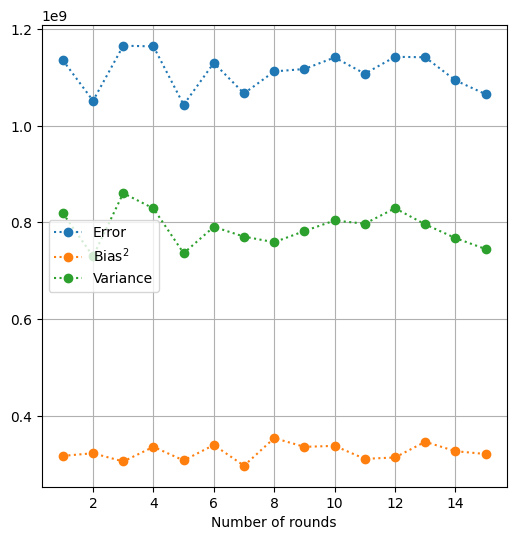

In [31]:
BVE(X_test, y_test, 15, MAE_wo_out[0])

Error/Bias/Variance at the last iteration: [9.49552252e+08 3.24516409e+08 6.25035843e+08]


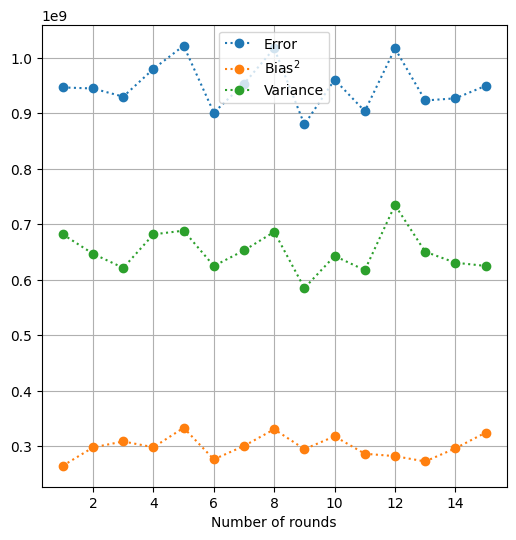

In [32]:
BVE(X_clean_test, y_clean_test, 15, MAE_clean_wo_out[0])

<div class="alert alert-block alert-warning">
<b>Considerazioni</b>
</div>

L'esito dei precedenti calcoli sul Bias, Varianza ed Errore evidenziano che l'errore è la misura più alta tra le tre.

Nonostante questo si vuole provare a migliorare l'andamento di varianza e bias, di fatti verranno applicati gli algoritmi di Bagging e Boosting.

Sebbene il bias sia già basso si vuole provare a vedere se c'è un margine di miglioramento. 

### Funzione che implementa il Bagging

In [33]:
def bagging(X_set, y_set, n_test, n_leaves):

    # Array per salvarsi i risultati ottenuti
    stats = np.array([])
    rounds = range(1, n_test + 1)
    
    # ------------------------------------------------------------------

    # Per ogni round
    for l in rounds:
        
        y_preds = np.array([])
        
        # ------------------------------------------------------------------

        # Per ogni prova
        for i in range(n_test):
            
            # Si creano dei campioni
            Xs, ys = resample(X_set, y_set, n_samples = int(0.67 * len(y_set)))

            # Si crea il modello e si allena sul campione
            model = DecisionTreeRegressor(max_leaf_nodes = n_leaves, random_state = 3)
            bmodel = BaggingRegressor(model, n_estimators = l)
            bmodel.fit(Xs,ys)

            # Si fa la predizione
            y_pred = bmodel.predict(X_set)
            y_preds = np.column_stack( [y_preds, y_pred] ) if y_preds.size else y_pred
            
        # ------------------------------------------------------------------

        # Calcolo dei valori richiesti
        dt_bias = (y_set - np.mean(y_preds,axis = 1)) ** 2
        dt_variance = np.var(y_preds, axis = 1)
        y_set = np.array(y_set)
        dt_error = (y_preds - y_set.reshape(-1, 1)) ** 2

        run_stats = np.array([dt_error.mean(), dt_bias.mean(), dt_variance.mean()])

        stats = np.column_stack( [stats, run_stats]) if stats.size else run_stats
        
    # ------------------------------------------------------------------

    # Grafico per vedere l'andamento dei valori calcolati
    fig, ax = plt.subplots(figsize=(6,6))

    ax.plot(rounds, stats[0,:], 'o:', label='Error')
    ax.plot(rounds, stats[1,:], 'o:', label='Bias$^2$')
    ax.plot(rounds, stats[2,:], 'o:', label='Variance')
    ax.set_xlabel('Number of Bagging rounds')
    ax.grid()
    ax.legend()

    print ("Error/Bias/Variance at the last iteration:", stats[:,-1])
    
    return stats

Error/Bias/Variance at the last iteration: [6.10771866e+08 3.81640501e+08 2.29131365e+08]


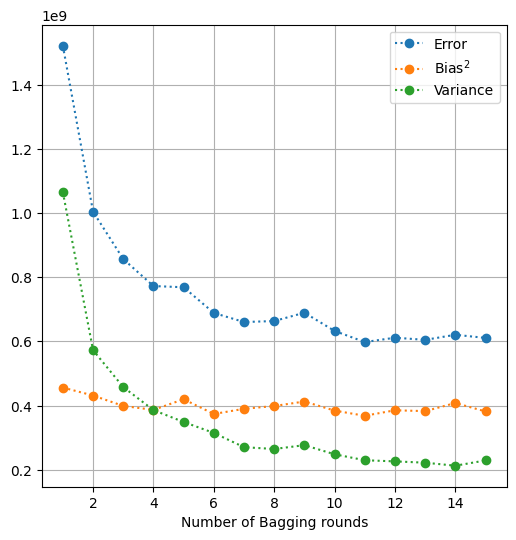

In [34]:
Bag_test = bagging(X_test, y_test, 15, MAE_wo_out[0])

Error/Bias/Variance at the last iteration: [5.55237597e+08 3.61558205e+08 1.93679393e+08]


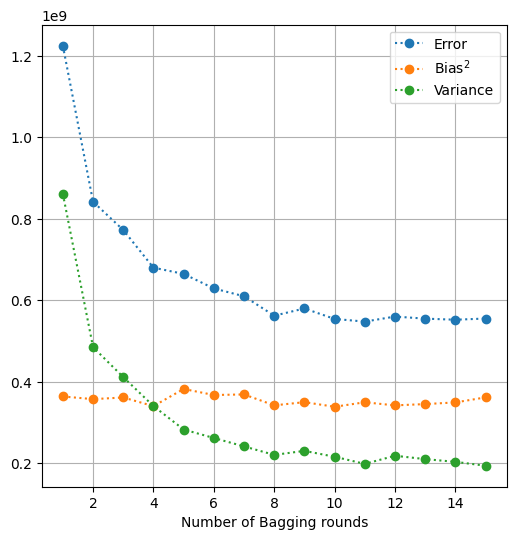

In [35]:
Bag_test_clean = bagging(X_clean_test, y_clean_test, 15, MAE_clean_wo_out[0])

<div class="alert alert-block alert-warning">
<b>Considerazioni</b>
</div>


Dopo aver applicato l'algoritmo di Bagging per abbassare la varianza, si nota che sul test set su cui si è applicato unicamente il One Hot Encoding, quest'ultima risulta essere più lineare rispetto a prima e inoltre si è anche abbassata notevolmente.

Un consistente miglioramento si può notare anche nel test set pulito.

Questo ci porta a dire che l'algoritmo ha prodotto un buon risultato.

Si vuole far notare che il bias rimane pressoché invariato, anche se leggermente più alto, al contrario dell'errore, il cui andamento è discendente. In ambo i casi l'errore arriva sul valore di circa 0.6.

### Funzione che implementa il Boosting

In [36]:
def boosting(X_set, y_set, n_test, n_leaves):

    # Array per salvarsi i risultati ottenuti
    stats = np.array([])
    rounds = range(1, n_test + 1)
    
    # ------------------------------------------------------------------
    
    # Per ogni round
    for l in rounds:
        
        y_preds = np.array([])
        
        # ------------------------------------------------------------------
        
        # Per ogni prova
        for i in range(n_test):
            
            # Si creano dei campioni
            Xs, ys = resample(X_set, y_set, n_samples = int(0.67 * len(y_set)) )

            # Si crea il modello e si allena sul campione
            model = DecisionTreeRegressor(max_leaf_nodes = n_leaves, random_state = 3)
            bmodel = AdaBoostRegressor(model, n_estimators = l)
            bmodel.fit(Xs,ys)

            # Si fa la predizione
            y_pred = bmodel.predict(X_set)
            y_preds = np.column_stack( [y_preds, y_pred] ) if y_preds.size else y_pred
            
        # ------------------------------------------------------------------

        # Calcolo dei valori richiesti
        dt_bias = (y_set - np.mean(y_preds, axis = 1)) ** 2
        dt_variance = np.var(y_preds, axis = 1)
        y_set = np.array(y_set)
        dt_error = (y_preds - y_set.reshape(-1, 1)) ** 2

        run_stats = np.array([dt_error.mean(), dt_bias.mean(), dt_variance.mean()])

        stats = np.column_stack( [stats, run_stats]) if stats.size else run_stats
        
    # ------------------------------------------------------------------

    # Grafico per vedere l'andamento dei valori calcolati
    fig, ax = plt.subplots(figsize=(6,6))

    ax.plot(rounds, stats[0,:], 'o:', label='Error')
    ax.plot(rounds, stats[1,:], 'o:', label='Bias$^2$')
    ax.plot(rounds, stats[2,:], 'o:', label='Variance')
    ax.set_xlabel('Number of Boosting rounds')
    ax.grid()
    ax.legend()

    print ("Error/Bias/Variance at the last iteration:", stats[:,-1])
    
    return stats

Error/Bias/Variance at the last iteration: [5.14210235e+08 2.32543733e+08 2.81666502e+08]


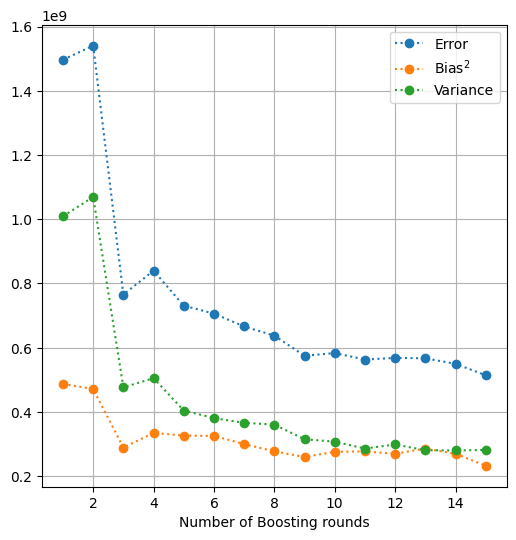

In [37]:
Bos_test = boosting(X_test, y_test, 15, MAE_wo_out[0])

Error/Bias/Variance at the last iteration: [4.72886186e+08 2.34088015e+08 2.38798171e+08]


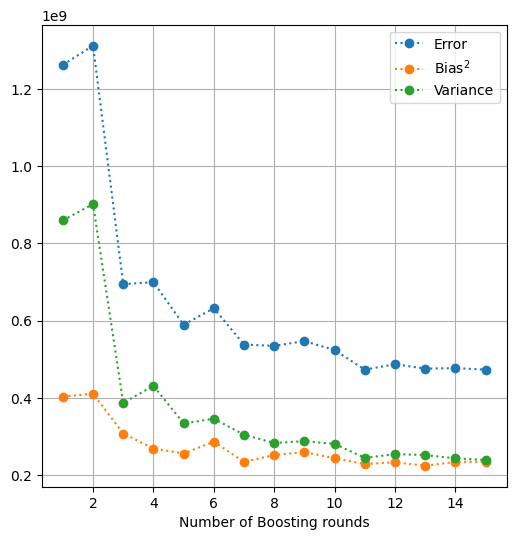

In [38]:
Bos_test_clean = boosting(X_clean_test, y_clean_test, 15, MAE_clean_wo_out[0])

<div class="alert alert-block alert-warning">
<b>Considerazioni</b>
</div>

Con l'algoritmo di Boosting nel test set sporco, il Bias diminuisce di tre punti percentuali, passando da 0.5 a circa 0.2. 

Anche nel test set pulito si può notare un miglioramento passando da 0.4 a quasi 0.2.

Allo stesso modo anche le altre due misure vengono migliorate notevolmente


### Funzione che mette a confronto i Bias, le Varianze e gli Errori individuati da Bagging e Boosting

In [39]:
def BVE_confront(bagging, boosting, n_test):
    
    rounds = range(1, n_test + 1)
    
    # Grafico ERRORE
    fig, ax = plt.subplots(figsize = (6, 6))

    ax.plot(rounds, bagging[0,:], 'o:', label = 'Error Bagging')
    ax.plot(rounds, boosting[0,:], 'o:', label = 'Error Boosting')

    ax.set_xlabel('Number of rounds')
    ax.grid()
    ax.legend()
    
    # Grafico BIAS
    fig, ax = plt.subplots(figsize = (6, 6))
    
    ax.plot(rounds, bagging[1,:], 'o:', label = 'Bias$^2$ Bagging')
    ax.plot(rounds, boosting[1,:], 'o:', label = 'Bias$^2$ Boosting')
    
    ax.set_xlabel('Number of rounds')
    ax.grid()
    ax.legend()
    
    # Grafico VARIANZA
    fig, ax = plt.subplots(figsize=(6,6))
    
    ax.plot(rounds, bagging[2,:], 'o:', label = 'Variance Bagging')
    ax.plot(rounds, boosting[2,:], 'o:', label = 'Variance Boosting')
    
    ax.set_xlabel('Number of rounds')
    ax.grid()
    ax.legend()

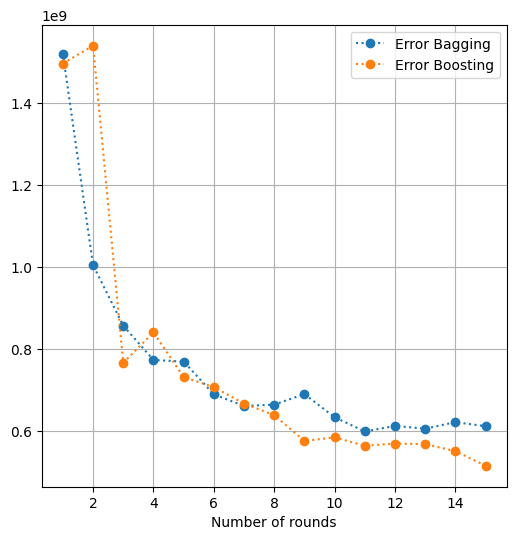

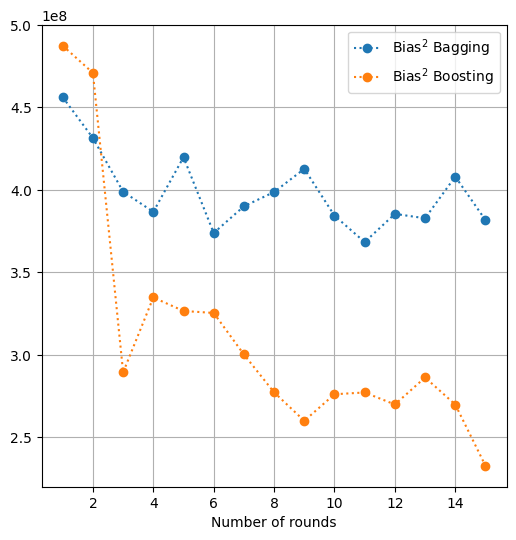

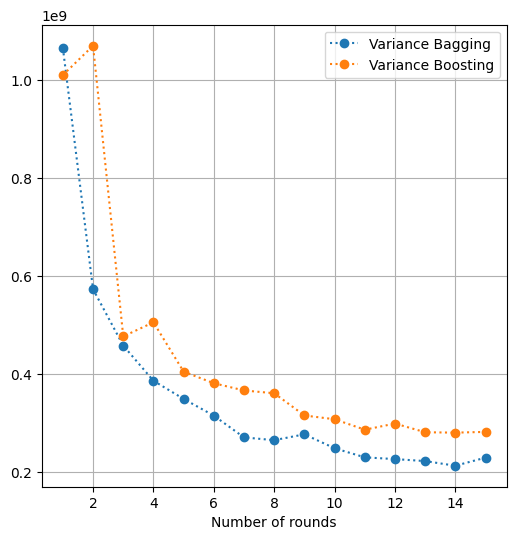

In [40]:
BVE_confront(Bag_test, Bos_test, 15)

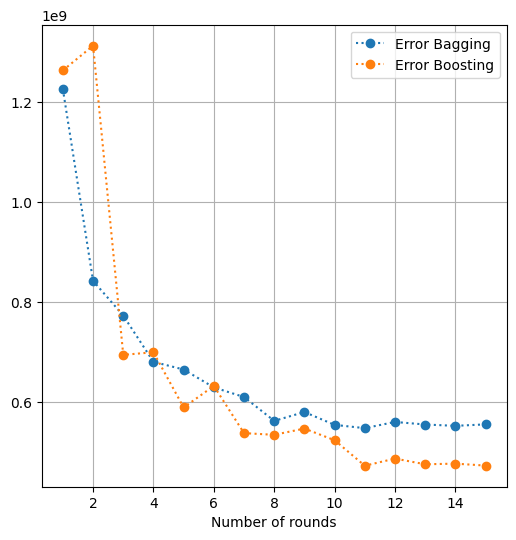

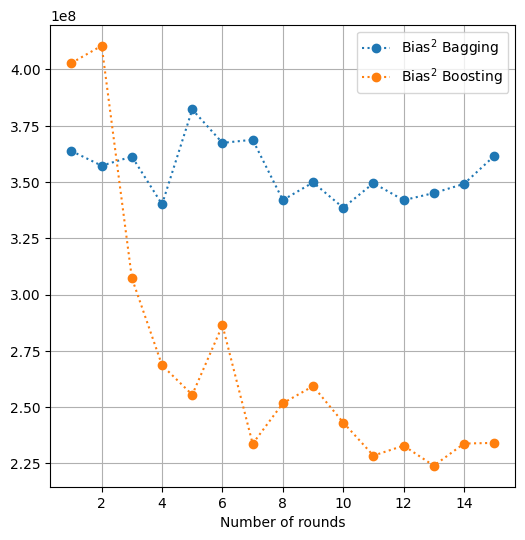

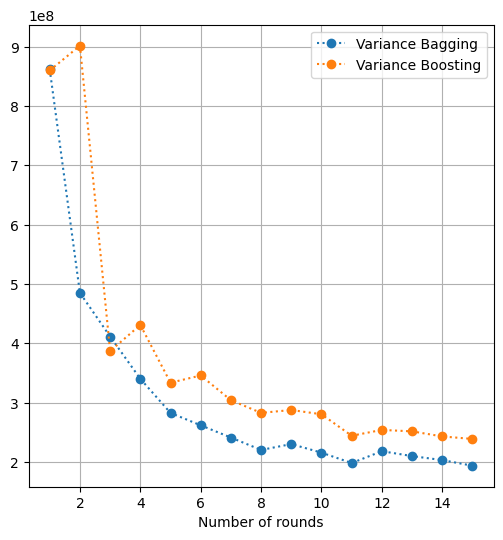

In [41]:
BVE_confront(Bag_test_clean, Bos_test_clean, 15)

<div class="alert alert-block alert-warning">
<b>Considerazioni</b>
</div>

Nel primo grafico, dove vengono mostrati gli errori si vede che in ambo i modelli essi tendono a seguire bene o male lo stesso andamento. Essi differiscono di poco, con un leggero vantaggio del boosting.

Il grafico successivo mostra che il boosting è effettivamente riuscito ad abbassare il Bias. Ciò si nota guardando il grafico, ove il bias del bagging si aggira attorno ai 3.50/3.75, il boosting riesce a farlo scendere sotto la soglia del 2.5.

L'ultimo grafico mostra un miglioramento sulla varianza da parte del bagging meno impattante rispetto a quello che ha avuto il boosting; nonostante questo si nota che l'algoritmo di bagging effettivamente abbassa la varianza.

<div class="alert alert-block alert-warning">
<b>Considerazioni finali</b>
</div>

Infine si può dire che le predizioni nel dataset pulito senza outliers rimangono anche se di poco inferiori alle predizioni del dataset pulito con gli outliers (0.0018%).

Al contrario nel dataset sporco senza outliers le prestazioni sono peggiorate del circa 5% rispetto allo stesso ma con gli outliers.

Nella parte finale si vede anche come l'applicare ai modelli gli algoritmi di bagging e boosting porti a notevoli miglioramenti sull'andamento delle misure di varianza e bias.